In [1]:
import os
print(os.path.abspath("./"))
print(os.path.abspath("../"))

import sys
sys.path.append("../")

c:\Users\Hasan\Work\akrule\notebooks
c:\Users\Hasan\Work\akrule


In [2]:
from akrule.time_series import AKRuleBasedTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prepration

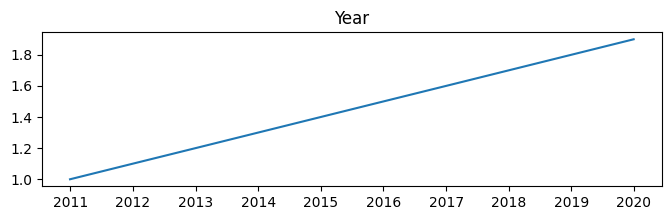

In [3]:
N = 10
data_year = np.ones(N)
trend = np.arange(0,N) / N
data_year += trend
df_year = pd.DataFrame()
df_year["y"] = data_year
df_year.index = pd.date_range(start='1/1/2010', end='1/1/2020', freq="1Y")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_year.index, df_year.y)
ax.set_title("Year");

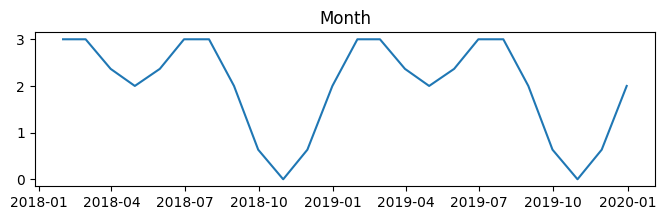

In [4]:
N = 24
x = np.arange(0,N)
y =  np.sin(4*np.pi*x/N)+np.cos(8*np.pi*x/N)+2
df_month = pd.DataFrame()
df_month["y"] = y
df_month.index = pd.date_range(start='1/1/2018', end='1/1/2020', freq="1M")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_month.index, df_month.y)
ax.set_title("Month");

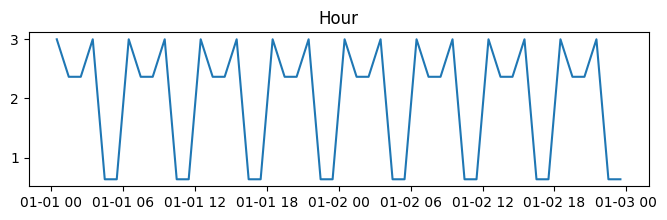

In [5]:
N = 48
x = np.arange(0,N)
y =  np.sin(16*np.pi*x/N)+np.cos(32*np.pi*x/N)+2
df_hour = pd.DataFrame()
df_hour["y"] = y
df_hour.index = pd.date_range(start='1/1/2020 00:30:00', end='1/3/2020', freq="1H")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_hour.index, df_hour.y)
ax.set_title("Hour");

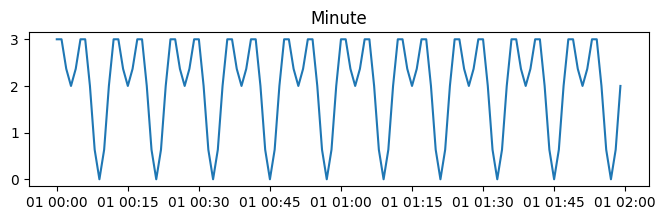

In [6]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_minute = pd.DataFrame()
df_minute["y"] = y
df_minute.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 02:00:00', freq="1T")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_minute.index, df_minute.y)
ax.set_title("Minute");

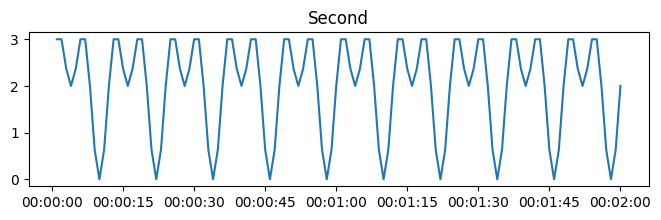

In [7]:
N = 120
x = np.arange(0,N)
y =  np.sin(20*np.pi*x/N)+np.cos(40*np.pi*x/N)+2
df_second = pd.DataFrame()
df_second["y"] = y
df_second.index = pd.date_range(start='1/1/2020 00:00:01', end='1/1/2020 00:02:00', freq="1S")

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df_second.index, df_second.y)
ax.set_title("Second");

# Test

In [286]:
import warnings

class AKRuleBasedTS():
    """
    """
    
    def __init__(self, freqs=[], tag_features=[], trend_level=0, holidays=False, fillna=True, inplace=False):
        self.freqs = freqs
        self.tag_features = tag_features
        self.trend_level = trend_level
        self.trend_x = None
        self.trend_dict = {}
        self.holidays = holidays
        self.fillna = fillna
        self.inplace = inplace
        
        for index, freq in enumerate(self.freqs):
            self.freqs[index] = freq.upper()
        
        self.freqs_order = ["YEARLY", "MONTHLY", "DAYOFMONTH", "HOURLY", "MINUTELY"]
        self.freq_order = None
        for freq_order in self.freqs_order:
            if freq_order.upper() in self.freqs:
                self.freq_order = freq_order
        if self.freq_order is None and fillna:
            self.fillna = False
            warnings.warn(f"Warning... There should be frequency like {self.freqs_order}!")
    
    def _check_data(self, X: pd.DataFrame):
        if not "time" in X.columns:
            raise KeyError("There is no time feature in DataFrame!")
        if not "y" in X.columns:
            raise KeyError("There is no y feature in DataFrame!")
        if not isinstance(X.time.values[0], np.datetime64):
            raise TypeError("time is not np.datetime64 format!")
        if not isinstance(X.y.values[0], (int, float)):
            raise TypeError("y is not numeric format!")
        for tag in self.tag_features:
            if not tag in X.columns:
                raise KeyError(f"There is no {tag} feature in DataFrame!")
    
    def _fillna(self, X: pd.DataFrame):
        def __fillna_group(group):
            group.infer_objects(copy=False).interpolate(method='linear', inplace=True)
            group.ffill(inplace=True)
            group.bfill(inplace=True)
            return group
        
        if self.freq_order == "YEARLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1Y")
        elif self.freq_order == "MONTHLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1M")
        elif self.freq_order == "DAYOFMONTH":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1D")
        elif self.freq_order == "HOURLY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1H")
        elif self.freq_order == "MINUTELY":
            time_index = pd.date_range(start=X.time.min(), end=X.time.max(), freq="1T")
        
        df_time = pd.DataFrame(time_index, columns=["time"])
        X_tags = X[self.tag_features].drop_duplicates()
        df_time = df_time.merge(X_tags, how="cross")

        X = X.merge(df_time, on=["time"]+self.tag_features, how="right")        
        X["isna"] = X.y.isna()
        if len(self.tag_features)>0:
            X = X.groupby(self.tag_features, as_index=False).apply(lambda group: __fillna_group(group))
        else:
            X.interpolate(method='linear', inplace=True)
            X.ffill(inplace=True)
            X.bfill(inplace=True)
        X.reset_index(drop=True, inplace=True)
        return X
    
    def _set_trend(self, X: pd.DataFrame):
        trend_cols = [f"res_polyfit{i}" for i in range(self.trend_level+1)]
        if len(self.tag_features)>0:
            tag = self.tag_features[0]
            value = X[tag].unique()[0]
            self.trend_x = np.arange(X[X[tag]==value].shape[0])
            res = X.groupby(self.tag_features).apply(lambda x: pd.Series(np.polyfit(self.trend_x, x.y, self.trend_level), 
                                                                                        index=trend_cols))
        else:
            self.trend_x = np.arange(X.shape[0])
            res = pd.DataFrame(np.polyfit(self.trend_x, X.y, self.trend_level).reshape(1,-1), columns=trend_cols)
            
        time_values = X["time"].unique()
        trend_preds = []
        for index, row in res.iterrows():
            self.trend_dict[index] = np.poly1d(row.values)
            trend_pred = pd.DataFrame()
            trend_pred["time"] = time_values
            trend_pred["y_trend"] = self.trend_dict[index](self.trend_x)
            if len(self.tag_features)>0: trend_pred[self.tag_features] = index
            trend_preds.append(trend_pred)
        trend_preds = pd.concat(trend_preds) if len(trend_preds)>1 else trend_preds[0]
        
        X = X.merge(trend_preds, on=["time"]+self.tag_features, how="left") if len(self.tag_features)>0 else pd.concat([X, trend_preds[["y_trend"]]], axis=1)
        X["y_notrend"] = X["y"] - X["y_trend"]
        return X
    
    def _set_freqs(self, X: pd.DataFrame):
        for freq in self.freqs:
            if freq.upper() == "YEARLY":
                X["year"] = X.time.dt.year
            elif freq.upper() == "MONTHLY":
                X["month"] = X.time.dt.month
            elif freq.upper() == "DAYOFYEAR":
                X["dayofyear"] = X.time.dt.dayofyear
            elif freq.upper() == "DAYOFMONTH":
                X["dayofmonth"] = X.time.dt.daysinmonth
            elif freq.upper() == "DAYOFWEEK":
                X["dayofweek"] = X.time.dt.dayofweek
            elif freq.upper() == "HOURLY":
                X["hour"] = X.time.dt.hour
            elif freq.upper() == "MINUTELY":
                X["minute"] = X.time.dt.minute
    
    def fit_predict(self, X_ori: pd.DataFrame):
        self._check_data(X_ori)
        X = X_ori if self.inplace else X_ori.copy()
        X = self._fillna(X) if self.fillna else X
        X = self._set_trend(X) if self.trend_level>0 else X
        display(X)
        self._set_freqs(X)
        display(X)
        return X
    

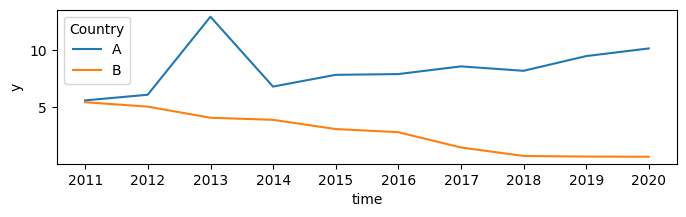

In [9]:
from akrule.time_series import get_yearly_data

df_year = get_yearly_data(N=10, max_value=10, noise_std=0.5, anomaly_percentage=10)

fig, ax = plt.subplots(figsize=(8,2))
sns.lineplot(data=df_year, x="time", y="y", hue="Country", ax=ax);

In [287]:
df_year_temp = df_year.copy()
#df_year_temp["time"] = df_year_temp["time"].astype(str)
#df_year_temp.loc[df_year_temp["time"]=="2011-12-31", "y"] = np.nan
df_year_temp = df_year_temp.loc[df_year_temp["time"]!="2011-12-31", :].copy()
df_year_temp = df_year_temp.loc[~((df_year_temp["time"]=="2019-12-31")&(df_year_temp["Country"]=="A")), :].copy()
df_year_temp = df_year_temp.loc[~((df_year_temp["time"]=="2010-12-31")&(df_year_temp["Country"]=="B")), :].copy()

model = AKRuleBasedTS(freqs=["yearly"], tag_features=["Country"], trend_level=1, inplace=False)
X = model.fit_predict(df_year_temp)

C:\Users\Hasan\AppData\Local\Temp\ipykernel_16956\190420913.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group.infer_objects(copy=False).interpolate(method='linear', inplace=True)
C:\Users\Hasan\AppData\Local\Temp\ipykernel_16956\190420913.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  group.infer_objects(copy=False).interpolate(method='linear', inplace=True)


,time,y,Country,Anomaly,isna,y_trend,y_notrend
0,2010-12-31,5.582627,A,1.0,False,8.084635,-2.502009
1,2011-12-31,9.230466,A,1.5,True,8.193954,1.036512
2,2012-12-31,12.878305,A,2.0,False,8.303273,4.575032
3,2013-12-31,6.786080,A,1.0,False,8.412591,-1.626511
4,2014-12-31,7.811225,A,1.0,False,8.521910,-0.710685
5,2015-12-31,7.876958,A,1.0,False,8.631228,-0.754270
6,2016-12-31,8.547323,A,1.0,False,8.740547,-0.193224
7,2017-12-31,8.161710,A,1.0,False,8.849865,-0.688155
8,2018-12-31,9.445499,A,1.0,False,8.959184,0.486315
9,2019-12-31,9.445499,A,1.0,True,9.068503,0.376996


,time,y,Country,Anomaly,isna,y_trend,y_notrend,year
0,2010-12-31,5.582627,A,1.0,False,8.084635,-2.502009,2010
1,2011-12-31,9.230466,A,1.5,True,8.193954,1.036512,2011
2,2012-12-31,12.878305,A,2.0,False,8.303273,4.575032,2012
3,2013-12-31,6.786080,A,1.0,False,8.412591,-1.626511,2013
4,2014-12-31,7.811225,A,1.0,False,8.521910,-0.710685,2014
5,2015-12-31,7.876958,A,1.0,False,8.631228,-0.754270,2015
6,2016-12-31,8.547323,A,1.0,False,8.740547,-0.193224,2016
7,2017-12-31,8.161710,A,1.0,False,8.849865,-0.688155,2017
8,2018-12-31,9.445499,A,1.0,False,8.959184,0.486315,2018
9,2019-12-31,9.445499,A,1.0,True,9.068503,0.376996,2019


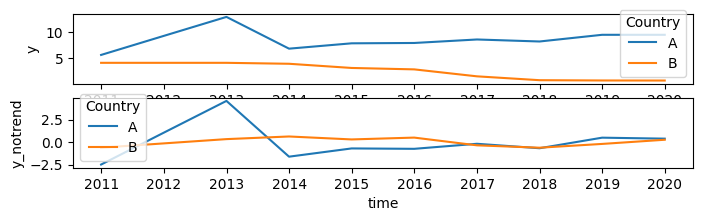

In [289]:
fig, axes = plt.subplots(2, figsize=(8,2))
sns.lineplot(data=X, x="time", y="y", hue="Country", ax=axes[0]);
sns.lineplot(data=X, x="time", y="y_notrend", hue="Country", ax=axes[1]);